# 결측치 처리

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pandas import read_csv
from numpy.random import randint

wine = read_csv('https://raw.githubusercontent.com/blueage98/ML/main/wine.csv', index_col=0)

In [92]:
df = wine.copy()
dfm = wine.copy()

In [93]:
for col in ['Alcohol', 'Ash']:
    for i in range(20):
        rand_idx = randint(0, len(df), 1)
        dfm.loc[rand_idx, col] = np.nan

dfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   class                         178 non-null    int64  
 1   Alcohol                       160 non-null    float64
 2   Malicacid                     178 non-null    float64
 3   Ash                           159 non-null    float64
 4   Alcalinity_of_ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total_phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid_phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color_intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  0D280_0D315_of_diluted_wines  178 non-null    float64
 13  Proline   

## 결측치 확인

Text(0, 0.5, '결측치 포함 데이터')

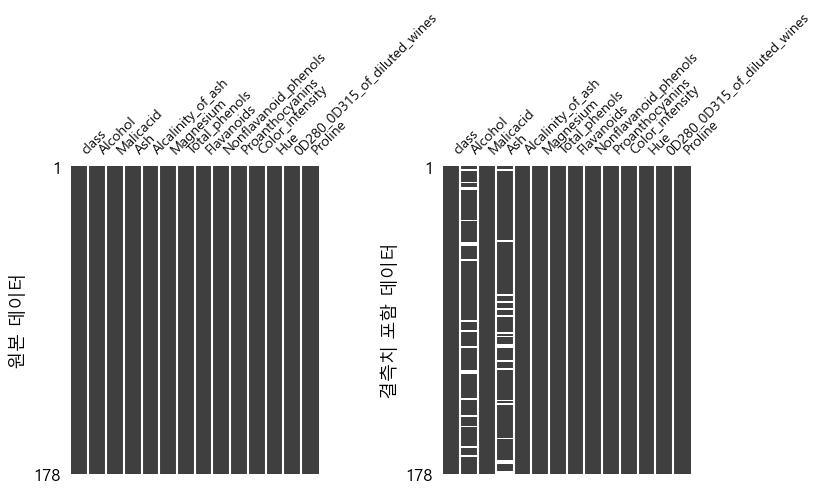

In [94]:
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 13
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus']=False

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt.subplots_adjust(wspace=0.5)

import missingno as msno
msno.matrix(df=df, figsize=(5,5), fontsize=10, ax=ax[0], sparkline=False)
ax[0].set_ylabel('원본 데이터')

msno.matrix(df=dfm, figsize=(5,5), fontsize=10, ax=ax[1], sparkline=False)
ax[1].set_ylabel('결측치 포함 데이터')


## 결측치 처리

### 상수값 대치 / 대표값 대치

In [95]:
# 상수값 대치
dfm_imp = dfm.fillna(333)

In [96]:
from sklearn.impute import SimpleImputer
from pandas import DataFrame

# 대표값 대치 : Strategy = mean / median / most_frequent
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
dfm_imp1 = imputer.fit_transform(dfm)
dfm_imp1 = pd.DataFrame(dfm_imp1, columns=dfm.columns)

Al_mean = dfm.Alcohol.mean()
As_mean = dfm.Ash.mean()

print('Mean values : Alcohol %.2f  Ash %.2f' %(Al_mean, As_mean))

dfm_imp1.head(10)

Mean values : Alcohol 12.99  Ash 2.37


,class,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline
0,1.0,14.230000,1.71,2.430000,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,1.0,13.200000,1.78,2.140000,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,1.0,12.989062,2.36,2.366101,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,1.0,14.370000,1.95,2.500000,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,1.0,13.240000,2.59,2.870000,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,1.0,14.200000,1.76,2.450000,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,1.0,14.390000,1.87,2.450000,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,1.0,14.060000,2.15,2.610000,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0
8,1.0,14.830000,1.64,2.170000,14.0,97.0,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045.0
9,1.0,12.989062,1.35,2.270000,16.0,98.0,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045.0


### 단순확률 대치법 (Single stochastic imputation)
- 유사한 데이터셋에서 랜덤하게 샘플링한 값으로 대치하는 방법
- Hot-deck : 현재 진행 중인 연구에서 비슷한 데이터로 대체
- Cold-deck: 외부의 비슷한 연구에서 가져온 데이터로 대체

In [97]:
def HotDeck(data, reference):
    imp = data.copy()
    check = imp.isna().sum()
    for col, val in zip(check.index, check.values):
        if val==0:
            continue
        else:
            imp[col]=imp[col].apply(lambda x: float(reference[col].sample(1).values) if str(x)=='nan' else x)
    return imp

# df 데이터가 dfm 데이터와 비슷한 성향을 가졌다고 가정하고 램덤 샘플링함.
dfm_imp2 = HotDeck(dfm, df)
dfm_imp2.isna().sum(0)
            


C:\Users\lsel\AppData\Local\Temp\ipykernel_10648\4043128794.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  imp[col]=imp[col].apply(lambda x: float(reference[col].sample(1).values) if str(x)=='nan' else x)
C:\Users\lsel\AppData\Local\Temp\ipykernel_10648\4043128794.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  imp[col]=imp[col].apply(lambda x: float(reference[col].sample(1).values) if str(x)=='nan' else x)


class                           0
Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
0D280_0D315_of_diluted_wines    0
Proline                         0
dtype: int64

### 다른 변수들로 모델링하여 결측치를 예측하는 방법
- KNN Imputer 사용 : 대표값 대치법보다는 정확할 때가 많다. 다만 메모리가 많이 필요하고 이상치에 민감.
- KNN 이외에도 회귀 및 분류 알고리즘을 사용할 수도 있다.

In [98]:
from sklearn.impute import KNNImputer
imputer=KNNImputer(n_neighbors=3)
dfm_imp3 = imputer.fit_transform(dfm)
dfm_imp3 = pd.DataFrame(wine_imp3, columns=dfm.columns)
dfm_imp3.isna().sum()

class                           0
Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
0D280_0D315_of_diluted_wines    0
Proline                         0
dtype: int64

### 보간법
- 결측치가 맨 앞에 있는 경우는 보간이 되지 않기 때문에 단순히 데이터 다음 값으로 채워야 하는 경우도 있다.

#### 보간법의 종류

- 선형 보간법 (Linear)
    - 선형회귀식을 구성하여 결측치 추정
- 이중선형 보간법 (Bilinear)
    - 선형함수를 두개 사용하여 2차원 평면 안에서 결측치를 추정
- 포물선 보간법
    - 2차 다항식을 써서 포물선을 그려 결측치를 추정
- 다항식 보간법
    - 2차 이상의 다항식으로 회귀식을 구성하여 결측치 추정
- 스플라인(Spline) 보간법
    - 값 구간을 분할하고 각 구간에서 낮은 차원의 다항식 사용
    - 각 점에서 앞/뒤 스플라인 함수가 미분이 가능하고 곡률은 같아야 함.
    - 각 구간의 다항식은 서로 자연스럽게 연결될 수 있어야 함.

#### 보간법 구현
- Pandas의 DataFrame.interpolate
    - linear : 선형 보간
    - zero / slinear / quadratic / cubic : 각각 0차 1차 2차 3차 스플라인 보간
    - spline / polynomial의 경우는 order 파라미터에 차수 지정해야 함.

In [99]:
dfm_imp4 = dfm.interpolate(method='linear')
dfm_imp4.isna().sum()

class                           0
Alcohol                         0
Malicacid                       0
Ash                             0
Alcalinity_of_ash               0
Magnesium                       0
Total_phenols                   0
Flavanoids                      0
Nonflavanoid_phenols            0
Proanthocyanins                 0
Color_intensity                 0
Hue                             0
0D280_0D315_of_diluted_wines    0
Proline                         0
dtype: int64

#### 보간법 성능 측정

In [100]:
# 결측치가 있는 행의 인덱스를 찾는 함수 정의
def find_missing_idx(data, column):
    return np.argwhere(np.array(data[[column]].isna().sum(axis=1)) > 0).ravel()

# 주어진 열의 성능비교 테이블 출력
def show_performance(data, column):
    missing_idx = find_missing_idx(data, column)
    
    # 지금까지 보간법을 적용하여 생성한 열들을 합쳐 데이터프레임 생성
    report = pd.DataFrame({'실제값':df[column], 'mean대치':dfm_imp1[column], 'Hotdeck':dfm_imp2[column], 'KNN대치':dfm_imp3[column], '선형보간':dfm_imp4[column]})
    missing_report = report.iloc[missing_idx, :]

    from sklearn.metrics import mean_absolute_error, mean_squared_error
    score_report = pd.DataFrame(index=['MAE', 'MSE'])
    for col in missing_report.columns:
        # MAE: 잔차의 절대값에 대한 평균
        mae = mean_absolute_error(missing_report['실제값'], missing_report[col])
        mse = mean_squared_error(missing_report['실제값'], missing_report[col])
        score_report.loc['MAE', col] = mae
        score_report.loc['MSE', col] = mse
    print(score_report)

In [101]:
# 'Alocohol' 열의 경우 실제값과 가장 가깝게 추정된 열은 선형보간법. 성능이 떨어지는 것은 HotDeck
show_performance(dfm, 'Alcohol')

     실제값    mean대치   Hotdeck     KNN대치      선형보간
MAE  0.0  0.630000  0.966111  0.027037  0.466852
MSE  0.0  0.572858  1.283350  0.013158  0.288130


In [102]:
# 'Ash'의 경우 KNN대치법의 성능이 가장 좋은 것으로, 선형보간법이 가장 떨어지는 것으로 나타남.
show_performance(dfm, 'Ash')

     실제값    mean대치   Hotdeck     KNN대치      선형보간
MAE  0.0  0.238332  0.282632  0.027544  0.283947
MSE  0.0  0.082120  0.140700  0.007257  0.114712


# 이상치 처리

## 이상치 진단 기준
1. ESD (Extreme studentized deviation)
2. 기하평균 - 2.5*표준편차 < data < 기하평균 + 2.5표준편차
3. Q1 - 1.5 x IQR < data < Q3 + 1.5 x IQR
4. 군집분석을 통한 이상치 진단 : DBSCAN 군집분석을 통해 -1로 분류되는 값을 이상치로 진단

## 이상치 처리 기법
1. 절단 (Trim or Truncation)
2. 조정 (Winzorizing)
3. 클리핑 (Clipping)

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randint
from pandas import read_csv

wine = read_csv('https://raw.githubusercontent.com/blueage98/ML/main/wine.csv')

df = wine.copy()
dfm= wine.copy()

mv_cols = ['Alcohol', 'Ash']

for col in mv_cols:
    for i in range(20):
        rand_idx = randint(0, len(wine), 1)
        dfm.loc[rand_idx, col] = np.nan

### 절단

In [104]:
# 이상치 절단 함수정의
def del_outlier(df, columns, method):
    columns = np.array(columns).flatten().tolist()
    check_df = df.loc[:,columns]
    if method=='iqr':
        IQR = check_df.quantile(0.75) - check_df.quantile(0.25)
        top = check_df.quantile(0.75) + 1.5*IQR
        dwn = check_df.quantile(0.25) - 1.5*IQR
    elif method == 'esd':
        std = check_df.std()
        mean = check_df.mean()
        top = mean+std*3
        dwn = mean-std*3
    prep_dfs = []
    for col in columns:
        out_id = check_df[ (check_df[col] >= top[col]) | (check_df[col] <= dwn[col]) ][col].index
        check_df.drop(out_id, axis=0, inplace=True)
        prep_dfs.append(check_df[[col]])
    if len(prep_dfs) == 1:
        prep_dfs = prep_dfs[0]
    return prep_dfs

#이상치 처리 전후 시각화 함수 정의
def before_after_boxplot(df1, df2, figsize=(10,5), fontsize=13):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1,2)
    plt.rcParams['figure.figsize']=figsize
    plt.rcParams['font.size']=fontsize
    plt.rcParams['axes.unicode_minus']=False
    for data, ax, title in zip([df1, df2], axes, ['Before', 'After']):
        data.boxplot(ax=ax)
        ax.set_title('{} ({})'.format(title, len(data)))
        margin = df1.std().values[0]/2
        ax.set_ylim(df1.min().values[0]-margin, df1.max().values[0]+margin)
    plt.show()  



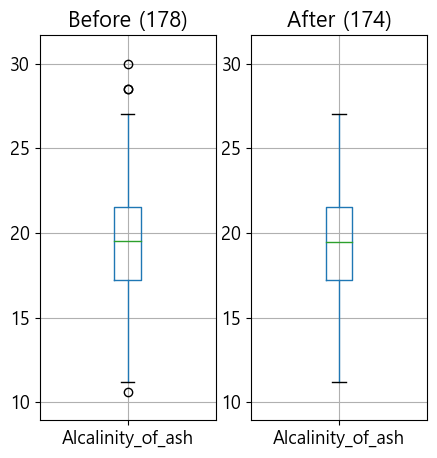

In [105]:
prep_Alc, prep_Ash = del_outlier(df, ['Alcalinity_of_ash', 'Ash'], method='iqr')

# Alcalinity_of_ash의 이상치 제거 전후
before = df[['Alcalinity_of_ash']]
before_after_boxplot(before, prep_Alc)

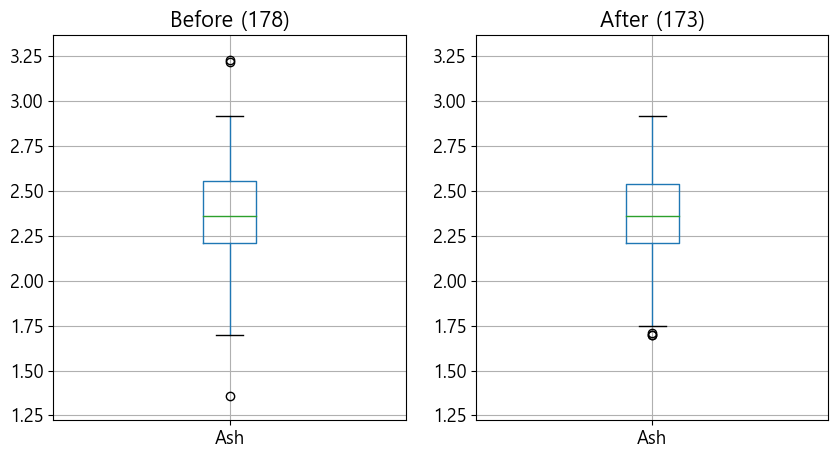

In [106]:
# Alcalinity_of_ash의 이상치 제거 전후
before = df[['Ash']]
before_after_boxplot(before, prep_Ash)

### 조정 (Winsorizing)

In [107]:
# 이상치 조정 함수정의
def win_outlier(df, columns, method):
    columns = np.array(columns).flatten().tolist()
    check_df = df.loc[:,columns]
    if method=='iqr':
        IQR = check_df.quantile(0.75) - check_df.quantile(0.25)
        top = check_df.quantile(0.75) + 1.5*IQR
        dwn = check_df.quantile(0.25) - 1.5*IQR
    elif method == 'esd':
        std = check_df.std()
        mean = check_df.mean()
        top = mean+std*3
        dwn = mean-std*3
    prep_dfs = []
    for col in columns:
        check_df[col] = check_df[col].clip(dwn[col], top[col])
    return check_df

### 클리핑
- 이상치의 상한/하한값을 설정하고, 해당 범위를 벗어나는 값은 상한/하한값으로 대체
- 이상치 경계값에 대한 확실한 정보가 있거나, 데이터를 제한하고 싶을 때 사용

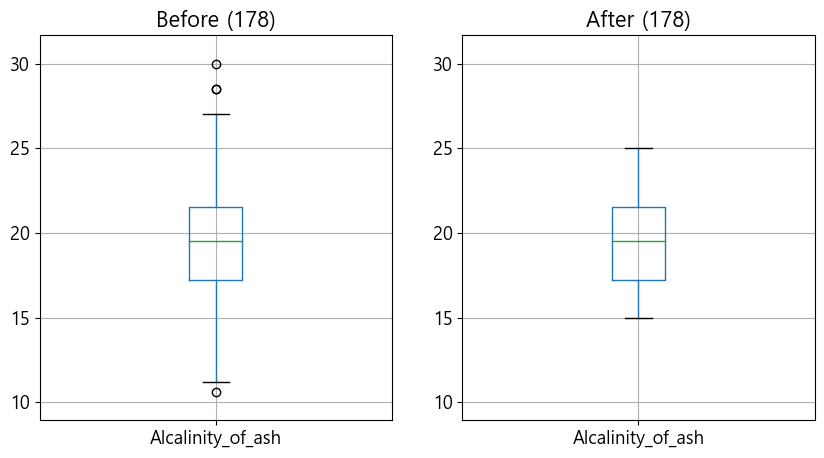

In [108]:
def clip_outlier(df, columns, downtop):
    columns = np.array(columns).flatten().tolist()
    check_df = df.loc[:, columns]
    for col, dt in zip(columns, downtop):
        check_df[col] = check_df[col].clip(dt[0], dt[1])
    return check_df

preps = clip_outlier(wine, ['Alcalinity_of_ash', 'Ash'], [(15, 25), (1.75, 3)])

# Alcalinity_of_Ash의 클리핑 전후
before = wine[['Alcalinity_of_ash']]
before_after_boxplot(before, preps[['Alcalinity_of_ash']])

# 클래스 불균형 처리
- 양/불량 판정의 경우 현실 세계의 데이터는 대부분 불량 데이터가 극히 적다.
- 어느 한 클래스의 데이터가 극히 적은 경우 많은 쪽의 클래스에 과대적합된다.
- 이런 경우 오버샘플링 혹은 언더샘플링이 필요하며, 이를 위한 imbalanced-learn 라이브러리 활용한다.
    - 오버샘플링
        - RandomOverSampler, SMOTE, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE, SDASYN 등
    - 언더샘플링
        - RandomUnderSampler, ClusterCentroids, CondensedNearestNeighbour, AllKNN 등

In [109]:
# 클래스 불균형 데이터 생성
from sklearn.datasets import load_breast_cancer
from pandas import DataFrame, merge, concat

data = load_breast_cancer()
df = DataFrame(np.c_[data['data'], data['target']], columns=["x%s"%i for i in range(data['data'].shape[1])]+['y'])

from collections import Counter
print("origninal data의 class 분포:", Counter(data['target']))
df1 = df[df['y']==0].sample(50)
df2 = df[df['y']==1].sample(250)

#전체 feature 중 4개만 사용
imb_df = concat([df1, df2]).reset_index(drop=True).iloc[:, -5:]
print('imbalanced data의 class 분포:', Counter(imb_df['y']))

features = imb_df.drop('y', axis=1)
target = imb_df['y']

print(imb_df.head(3))

origninal data의 class 분포: Counter({1: 357, 0: 212})
imbalanced data의 class 분포: Counter({1.0: 250, 0.0: 50})
      x26     x27     x28      x29    y
0  0.6922  0.1785  0.2844  0.11320  0.0
1  0.3759  0.1510  0.3074  0.07863  0.0
2  0.3879  0.2091  0.3537  0.08294  0.0


In [110]:
import seaborn as sns

def showComparation(df, oversampled):
    fig, ax = plt.subplots(1,2)
    ax[0].set_title('imbalanced')
    ax[1].set_title('oversampled')
    sns.scatterplot(x='x28', y='x29', hue='y', data=df, ax=ax[0], alpha=0.5, style='y', markers=['s', 'X'])
    sns.scatterplot(x='x28', y='x29', hue='y', data=oversampled, ax=ax[1], alpha=0.5, style='y', markers=['s', 'X'])
    plt.show()

## 오버샘플링

### RandomOverSampler
- 개수가 적은 클래스의 데이터를 단순 복제하여 비율을 맞춤
- 분포의 변화는 없으나, 복제된 데이터의 가중치가 높아져 과적합 위험

imbalanced data의 class 분포 : Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포 : Counter({0.0: 250, 1.0: 250})


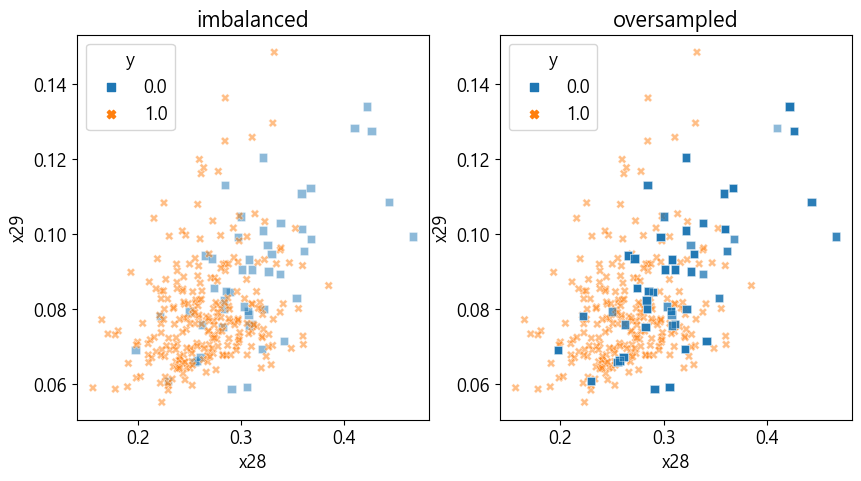

In [111]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler()
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포 : %s' %Counter(target))
print('oversampled data의 class 분포 : %s' %Counter(bal_target))

import seaborn as sns
over_df1 = DataFrame(np.c_[bal_features, bal_target], columns=imb_df.columns)

showComparation(imb_df, over_df1)

### SMOTE (Synthetic minority oversampling technique)
- 임의의 소수 클래스 데이터로부터 인근 소수 클래스 사이에 새로운 데이터를 생성하는 방법

imbalanced data의 class 분포 : Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포 : Counter({0.0: 250, 1.0: 250})


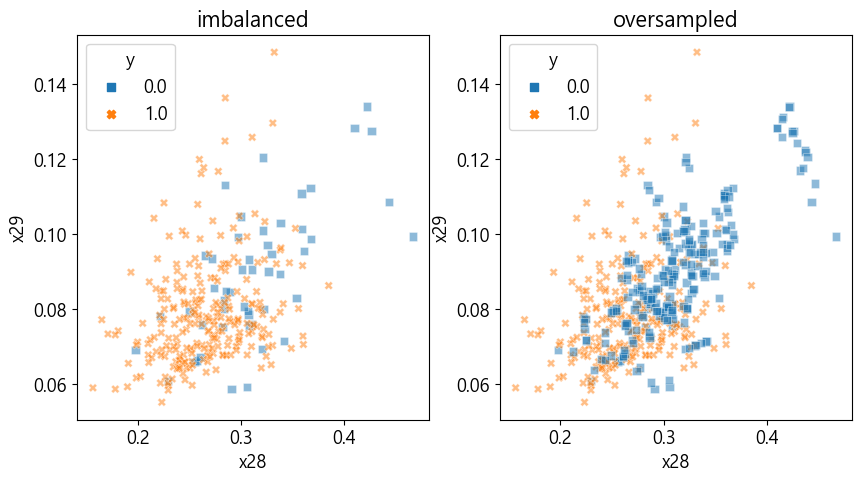

In [112]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=42, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포 : %s' %Counter(target))
print('oversampled data의 class 분포 : %s' %Counter(bal_target))

over_df2 = DataFrame(np.c_[bal_features, bal_target], columns=imb_df.columns)

showComparation(imb_df, over_df2)

### BorderlineSMOTE
- 다수 클래스와 소수 클래스를 구분하는 선을 그을 때, 그 경계선 근처의 데이터에 대해서만 SMTOE를 적용하는 방법
- 임의 소수 클래스 데이터를 뽑아 KNN 시행 시, 다수 클래스의 데이터가 함께 뽑혔으면 Borderline으로 보고 SMOTE 적용
- 따라서 경계선 근처에서만 데이터가 추가됨

imbalanced data의 class 분포 : Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포 : Counter({0.0: 250, 1.0: 250})


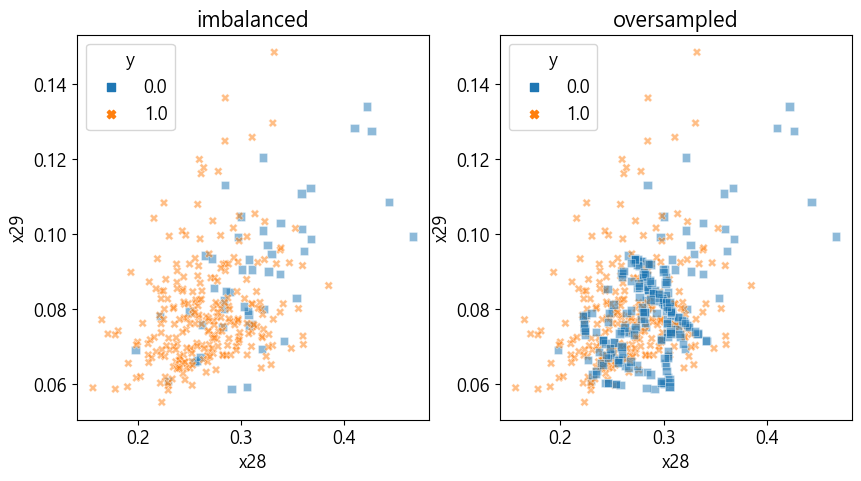

In [113]:
from imblearn.over_sampling import BorderlineSMOTE
os = BorderlineSMOTE(random_state=0, k_neighbors=5)
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포 : %s' %Counter(target))
print('oversampled data의 class 분포 : %s' %Counter(bal_target))

over_df3 = DataFrame(np.c_[bal_features, bal_target], columns=imb_df.columns)

showComparation(imb_df, over_df3)

### KMeansSMOTE
- K-Means 알고리즘을 우선 적용하여 전체 데이터를 클러스터링한 후,
- 다수 클래스 데이터가 포함된 cluster는 oversampling 대상에서 제외하고,
- 소수 클래스 데이터만 존재하는 cluster에 대해 그 주변 값으로 샘플을 추가한다.


c:\Users\lsel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


imbalanced data의 class 분포 : Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포 : Counter({0.0: 252, 1.0: 250})


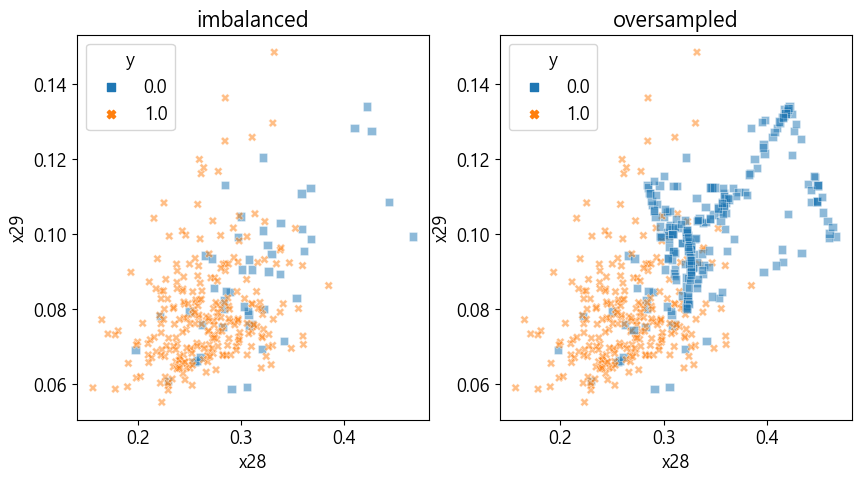

In [114]:
from imblearn.over_sampling import KMeansSMOTE
os = KMeansSMOTE(random_state=0, k_neighbors=5)
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포 : %s' %Counter(target))
print('oversampled data의 class 분포 : %s' %Counter(bal_target))

over_df4 = DataFrame(np.c_[bal_features, bal_target], columns=imb_df.columns)

showComparation(imb_df, over_df4)

### SVMSMOTE
- SVM 알고리즘으로 데이터를 우선 학습한 후, 
- 생성된 Support Vector 데이터 중 소스 클래스의 데이터들을 Borderline데이터로부터 SMOTE를 적용한다.

imbalanced data의 class 분포 : Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포 : Counter({0.0: 250, 1.0: 250})


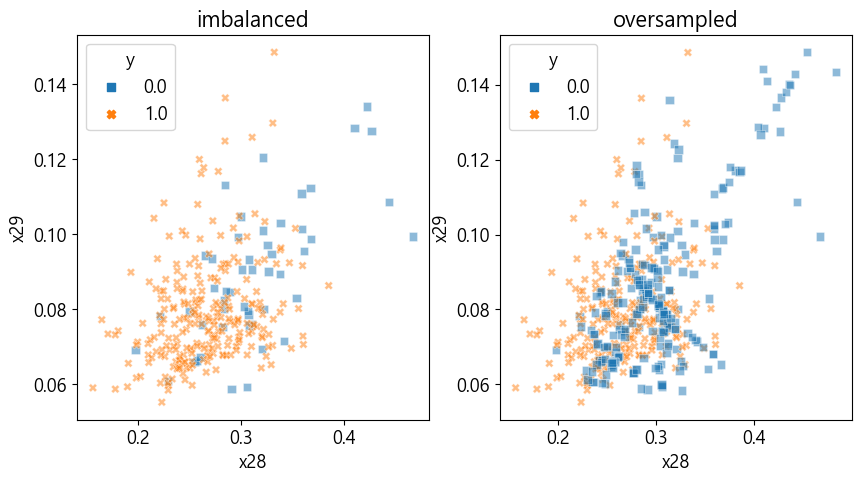

In [115]:
from imblearn.over_sampling import SVMSMOTE
os = SVMSMOTE(random_state=0)
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포 : %s' %Counter(target))
print('oversampled data의 class 분포 : %s' %Counter(bal_target))

over_df5 = DataFrame(np.c_[bal_features, bal_target], columns=imb_df.columns)

showComparation(imb_df, over_df5)

### SDASYN (Adaptive synthetic sampling)
- 인접한 데이터의 소스 클래스와 다수 클래스의 비율에 따라 생성하는 샘플의 개수 결정
- 인접한 데이터 중 소수 클래스의 밀도에 반비례하여 샘플 생성

imbalanced data의 class 분포 : Counter({1.0: 250, 0.0: 50})
oversampled data의 class 분포 : Counter({1.0: 250, 0.0: 245})


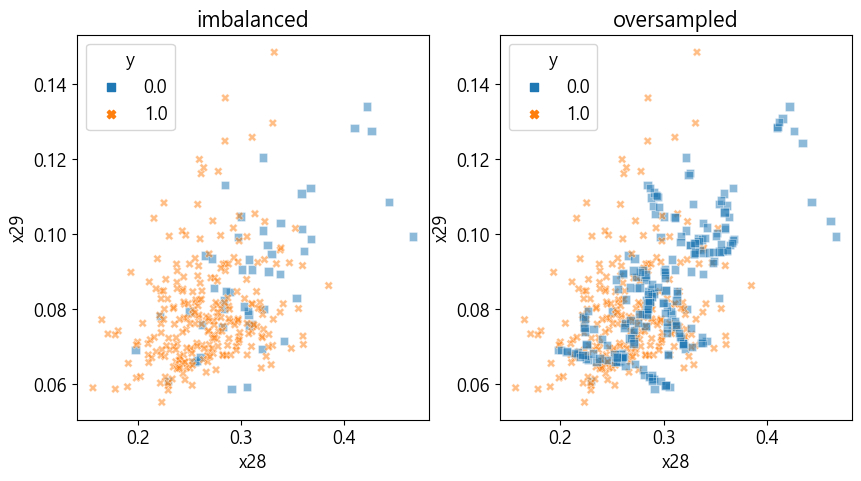

In [116]:
from imblearn.over_sampling import ADASYN
os = ADASYN(random_state=42, n_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print('imbalanced data의 class 분포 : %s' %Counter(target))
print('oversampled data의 class 분포 : %s' %Counter(bal_target))

over_df6 = DataFrame(np.c_[bal_features, bal_target], columns=imb_df.columns)

showComparation(imb_df, over_df6)

### 오버샘플링 알고리즘 성능 비교


In [117]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

data = [imb_df, over_df1, over_df2, over_df3, over_df4, over_df5, over_df6]
data_title = ['No oversampling', 'RandomOverSampler', 'SMOTE', 'BorderlineSMOTE', 'KMeansSMOTE', 'SVMSMOTE', 'ADASYN']
scores = DataFrame(index=['Train scc', 'Test acc', 'Train F1', 'Test F1'], columns=data_title)

for df, title in zip(data, data_title):
    X = df.drop('y', axis=1)
    y = df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    lr = LogisticRegression(max_iter=300)
    lr.fit(X_train, y_train)
    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)
    scores.loc['Train scc', title] = accuracy_score(y_train, pred_train)
    scores.loc['Test acc', title] = accuracy_score(y_train, pred_train)
    scores.loc['Train F1', title] = f1_score(y_train, pred_train)
    scores.loc['Test F1', title] = f1_score(y_train, pred_train)

print(scores)

          No oversampling RandomOverSampler     SMOTE BorderlineSMOTE  \
Train scc        0.857778             0.904  0.938667        0.922667   
Test acc         0.857778             0.904  0.938667        0.922667   
Train F1         0.921951          0.906736  0.933333        0.916427   
Test F1          0.921951          0.906736  0.933333        0.916427   

          KMeansSMOTE  SVMSMOTE    ADASYN  
Train scc    0.941489     0.944  0.897574  
Test acc     0.941489     0.944  0.897574  
Train F1     0.941489  0.938776  0.890173  
Test F1      0.941489  0.938776  0.890173  


# 데이터 변환
- 특성의 척도(Scale)을 바꾸는 것을 의
- 값 범위가 크거나, 특성 간 단위가 크게 다를 경우 왜곡되기 쉽다.
    - 선형 회귀, 로지스틱 회귀
    - 거리 기반 모델
    - 신경망
- 한편 DecisionTree 계열의 알고리즘은 척도에서 자유롭다.

In [118]:
import pandas as pd
import numpy as np
from numpy.random import randint
from pandas import read_csv
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

diab = pd.read_csv('https://raw.githubusercontent.com/blueage98/ML/main/diabetes.csv')

X = diab.filter(['Pregnancies', 'BloodPressure', 'BMI', 'Age'])
y = diab['Outcome']

## 수치형 변수 변환

In [119]:
def TestScaler(data, scaler):
    print('[Before] feature별 데이터 분포 확인: ')
    print(data.describe().loc[['mean', 'std', 'max', 'min'], :])

    # 표준화 수행
    scaled = scaler.fit_transform(data)
    scaled = pd.DataFrame(scaled, columns=data.columns)
    print('[After] feature별 데이터 분포 확인:')
    print(scaled.describe().loc[['mean', 'std', 'max', 'min'], :])

    # 표준화 전후 데이터 시각화
    import seaborn as sns
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    for col, a in zip(data.columns, [0.02, 0.1, 0.6, 1]):
        sns.kdeplot(data[col],alpha=a, legend=True, ax=ax[0], fill=True, color='r')
    ax[0].legend(data.columns)
    ax[0].set_xlabel('feature')
    ax[0].set_title('Before scaling')
    for col, a in zip(scaled.columns, [0.02, 0.1, 0.6, 1]):
        sns.kdeplot(scaled[col],alpha=a, legend=True, ax=ax[1], fill=True, color='r')
    ax[1].legend(scaled.columns)
    ax[1].set_xlabel('feature')
    ax[1].set_title('After scaling')
    plt.show()

    return scaled

### Standardization

[Before] feature별 데이터 분포 확인: 
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000
[After] feature별 데이터 분포 확인:
       Pregnancies  BloodPressure           BMI           Age
mean -6.476301e-17   1.503427e-17  2.590520e-16  1.931325e-16
std   1.000652e+00   1.000652e+00  1.000652e+00  1.000652e+00
max   3.906578e+00   2.734528e+00  4.455807e+00  4.063716e+00
min  -1.141852e+00  -3.572597e+00 -4.060474e+00 -1.041549e+00


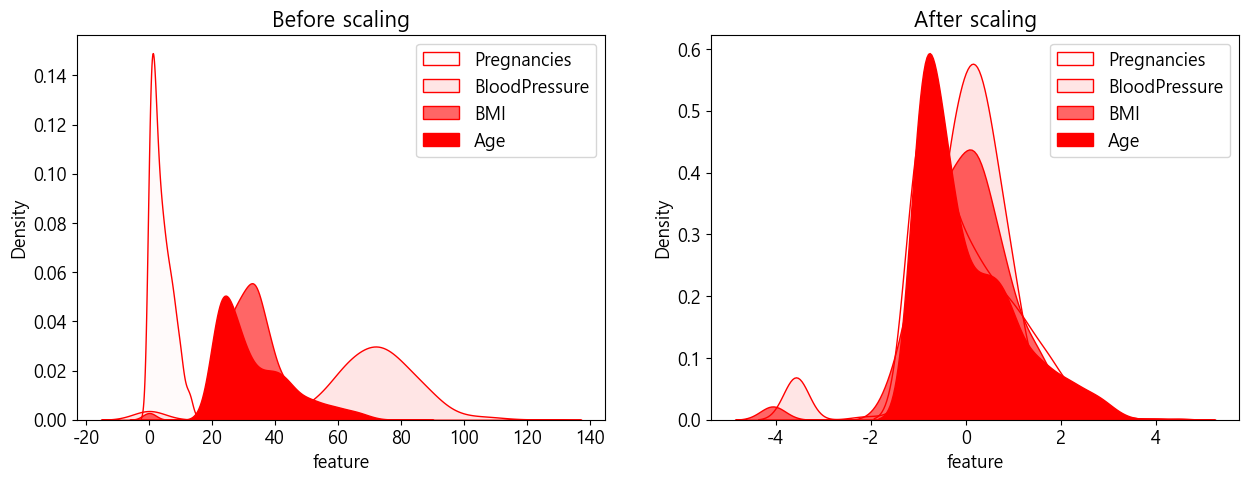

In [120]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
ss_X = TestScaler(X, scaler)

### MinMax Scaling

[Before] feature별 데이터 분포 확인: 
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000
[After] feature별 데이터 분포 확인:
      Pregnancies  BloodPressure       BMI       Age
mean      0.22618       0.566438  0.476790  0.204015
std       0.19821       0.158654  0.117499  0.196004
max       1.00000       1.000000  1.000000  1.000000
min       0.00000       0.000000  0.000000  0.000000


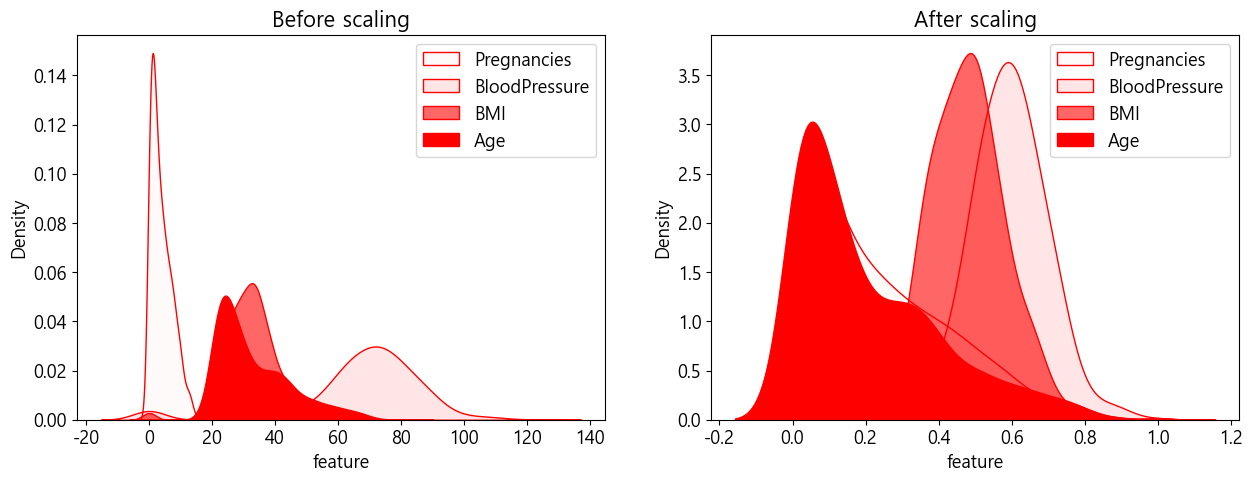

In [121]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
mm_X = TestScaler(X, scaler)

### Robust Scaling
- 특성들이 같은 스케일을 갖게 된다는 측면에서 표준화 스케일링과 유사
- 단, 평균과 분산 대신 중앙값과 사분위수를 사용하기에 이상치의 영향을 받지 않는다.
- (데이터값 - 중앙값)/IQR

[Before] feature별 데이터 분포 확인: 
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000
[After] feature별 데이터 분포 확인:
      Pregnancies  BloodPressure       BMI       Age
mean     0.169010      -0.160807 -0.000798  0.249464
std      0.673916       1.075323  0.847759  0.691778
max      2.800000       2.777778  3.774194  3.058824
min     -0.600000      -4.000000 -3.440860 -0.470588


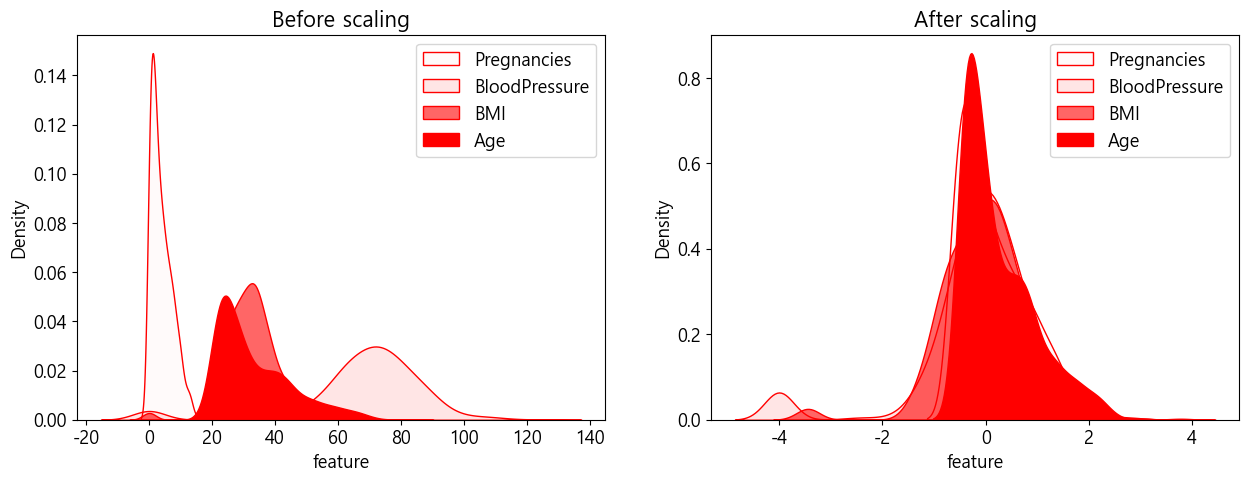

In [122]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
rs_X = TestScaler(X, scaler)

### Quantile Scaling
- 균등분포 방법 (output_distribution=uniform)
    - 분위 수를 n_quantiles로 설정하여, 분위 수에 맞게 데이터를 재배치
    - np.quantile로 각 분위의 데이터를 0~1 범위로 균등하게 퍼뜨림.
    - 따라서 이상치의 영향을 받지 않음.
- 정규분포 방법 (output_distribution=normal)
    - 평균이 0, 표준편차는 1인 정규분포로 변환
    - StandardScaler도 평균 0, 표준편차 1이지만 정규분포가 아닌 원래의 분포를 그대로 유지

[Before] feature별 데이터 분포 확인: 
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000
[After] feature별 데이터 분포 확인:
      Pregnancies  BloodPressure       BMI       Age
mean     0.489773       0.499110  0.499972  0.496769
std      0.303331       0.290718  0.289391  0.294365
max      1.000000       1.000000  1.000000  1.000000
min      0.000000       0.000000  0.000000  0.000000


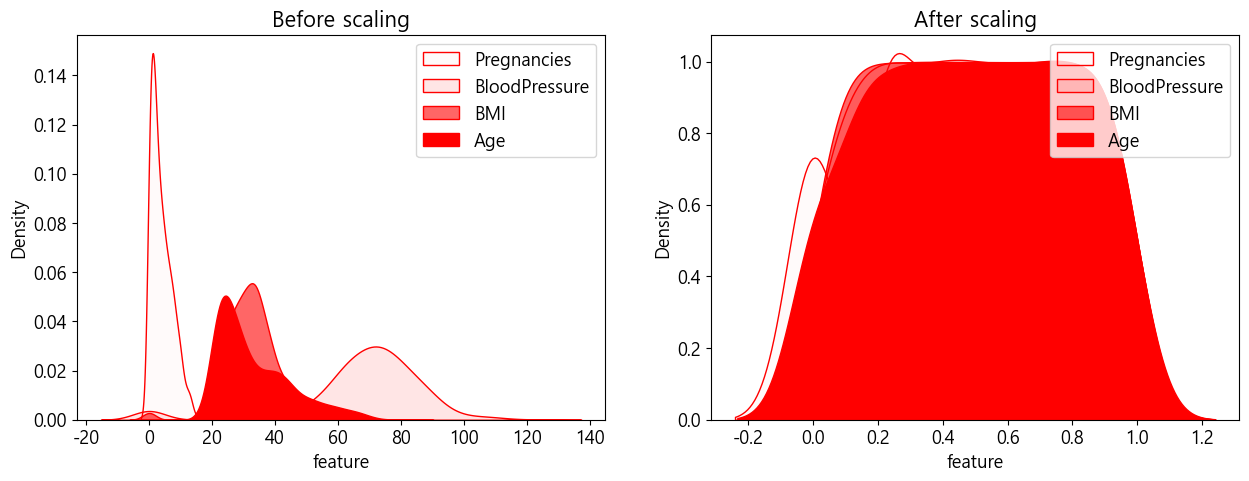

In [123]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(output_distribution='uniform', n_quantiles=len(X))
qtu_X = TestScaler(X, scaler)

[Before] feature별 데이터 분포 확인: 
      Pregnancies  BloodPressure        BMI        Age
mean     3.845052      69.105469  31.992578  33.240885
std      3.369578      19.355807   7.884160  11.760232
max     17.000000     122.000000  67.100000  81.000000
min      0.000000       0.000000   0.000000  21.000000
[After] feature별 데이터 분포 확인:
      Pregnancies  BloodPressure       BMI       Age
mean    -0.518602      -0.137647 -0.034803 -0.270105
std      2.066619       1.426041  1.150110  1.696606
max      5.199338       5.199338  5.199338  5.199338
min     -5.199338      -5.199338 -5.199338 -5.199338


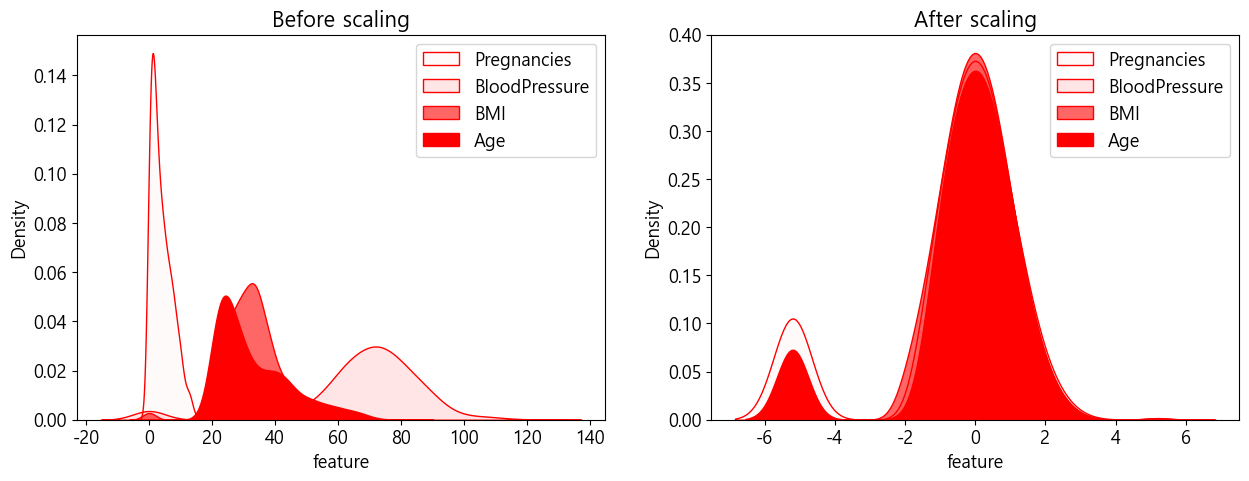

In [124]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer(output_distribution='normal', n_quantiles=len(X))
qtn_X = TestScaler(X, scaler)

### Scaler 간 성능 비교

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

data = [X, ss_X, mm_X, rs_X, qtu_X, qtn_X]
y = diab['Outcome']

data_title = ['no scaling', 'StandardScaler', 'MinMaxScaler', 'RobustScaler', 'QuantileUniform', 'QutantileNormal']
scores = pd.DataFrame(index=['Train acc', 'Test acc', 'Train F1', 'Test F1'], columns=data_title)
coeffs = pd.DataFrame(index=data_title, columns=X.columns)
for df, title in zip(data, data_title):
    X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=0)
    lr = LogisticRegression(max_iter=300)
    lr.fit(X_train, y_train)
    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)
    scores.loc['Train acc', title] = accuracy_score(y_train, pred_train)
    scores.loc['Test acc', title] = accuracy_score(y_test, pred_test)
    scores.loc['Train F1', title] = f1_score(y_train, pred_train)
    scores.loc['Test F1', title] = f1_score(y_test, pred_test)
    coeffs.loc[title, :] = lr.coef_
print(scores)

          no scaling StandardScaler MinMaxScaler RobustScaler QuantileUniform  \
Train acc     0.6875       0.689236     0.682292     0.689236        0.701389   
Test acc    0.692708       0.692708     0.682292     0.692708        0.692708   
Train F1    0.470588       0.471976     0.403909     0.471976         0.50289   
Test F1      0.40404        0.40404      0.26506      0.40404        0.427184   

          QutantileNormal  
Train acc        0.680556  
Test acc         0.697917  
Train F1         0.468208  
Test F1          0.395833  


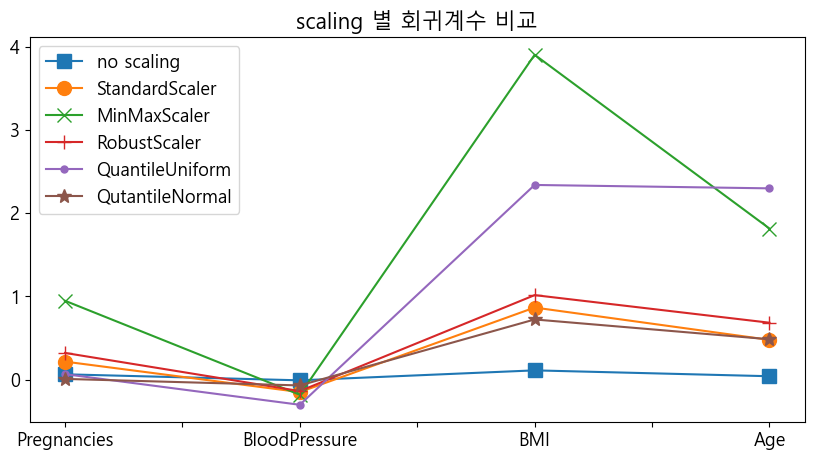

In [126]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.set_title('scaling 별 회귀계수 비교')
for i, marker in enumerate(['s', 'o', 'x', '+', '.', '*']):
    coeffs.T.iloc[:,i].plot(ax=ax, marker=marker, ms=10)
ax.legend()
plt.show()

### 로그변환
- 로그함수는 x값이 작을 때는 상대적으로 넓게 데이터를 퍼뜨리고 클수록 지수적으로 좁은 범위로 퍼뜨리는 역할을 한다.
- 따라서 데이터가 너무 작은 값 범위에 몰려 있는 경우를 이를 정규분포 모양에 가깝게 조정할 목적으로 사용한다.
<br><br>
![로그함수의 효과](https://i.namu.wiki/i/OiwWNmzfBTmYd-BKxNh19g34SQZOe1hgqnbAwDi8B5kK5bdi1YT868m4gkB2aO3Hzeg2xpQJkofLQpQeBfbuEoNb8t6H0KukTYuIApXEttmePnHy6s1EdVuKV5fwbbgGTXODwBrqVvhyVNYNcpU7Qw.webp)

In [127]:
import pandas as pd

realestate = pd.read_csv('https://raw.githubusercontent.com/blueage98/ML/main/realestate.csv')

X = realestate.filter(['X2 house age','X3 distance to the nearest MRT station','X4 number of convenience stores']) \
                .rename(columns={'X2 house age':'X2','X3 distance to the nearest MRT station':'X3', 'X4 number of convenience stores':'X4'})
y = realestate[['Y house price of unit area']]

In [128]:
# 상용로그
y_log = np.log10(y)

# 자연로그
y_log2 = np.log(y)

# 자연로그 + 1
y_log3 = np.log1p(y)

# 데이터의 절대값에 자연로그 변환을 한 후, 데이터의 원래 부호를 붙임
y_log4 = np.sign(y) * np.log(np.abs(y))

### 거듭제곱 변환
1. Box-cox 방법
    - 데이터를 정규분포에 가깝게 만들기 위함. 
    - 정규성을 가정하는 분석법이나 정상성을 요구하는 분석법에 앞서 전처리에 사용
    - 데이터가 모두 양수여야 하므로, 어떤 값을 더해 양수로 만든 후 사용 가능
    - lambda가 0인 경우 np.log(x)와 동일함
2. Yeo-Johnson 방법
    - 목적은 Box-cox와 동일. 단, 실수에도 사용 가능

In [129]:
from sklearn.preprocessing import PowerTransformer

PTB = PowerTransformer(method = 'box-cox')
PTY = PowerTransformer(method = 'yeo-johnson')

y_ptb = pd.DataFrame(PTB.fit_transform(y), columns=y.columns)
y_pty = pd.DataFrame(PTY.fit_transform(y), columns=y.columns)

# 변환된 데이터를 원래 데이터로 역변환 : inverse_transform
y_ptb_inv = pd.DataFrame(PTB.inverse_transform(y_ptb), columns=y.columns)
print("**원본: \n", y.head(4), '\n')
print("**변환 후: \n", y_ptb.head(4), '\n')
print("**역 변환: \n", y_ptb_inv.head(4), '\n')

**원본: 
    Y house price of unit area
0                        37.9
1                        42.2
2                        47.3
3                        54.8 

**변환 후: 
    Y house price of unit area
0                    0.069462
1                    0.376242
2                    0.723903
3                    1.208354 

**역 변환: 
    Y house price of unit area
0                        37.9
1                        42.2
2                        47.3
3                        54.8 



### 로그변환 성능 비교

         no scaling  log10log     log1p abs+log+sign   box-cox yeo-johnson
Train r2   0.535784  0.653202  0.653202     0.651243  0.653202    0.595276
Test r2     0.55253  0.574612  0.574612     0.578234  0.574612    0.577501


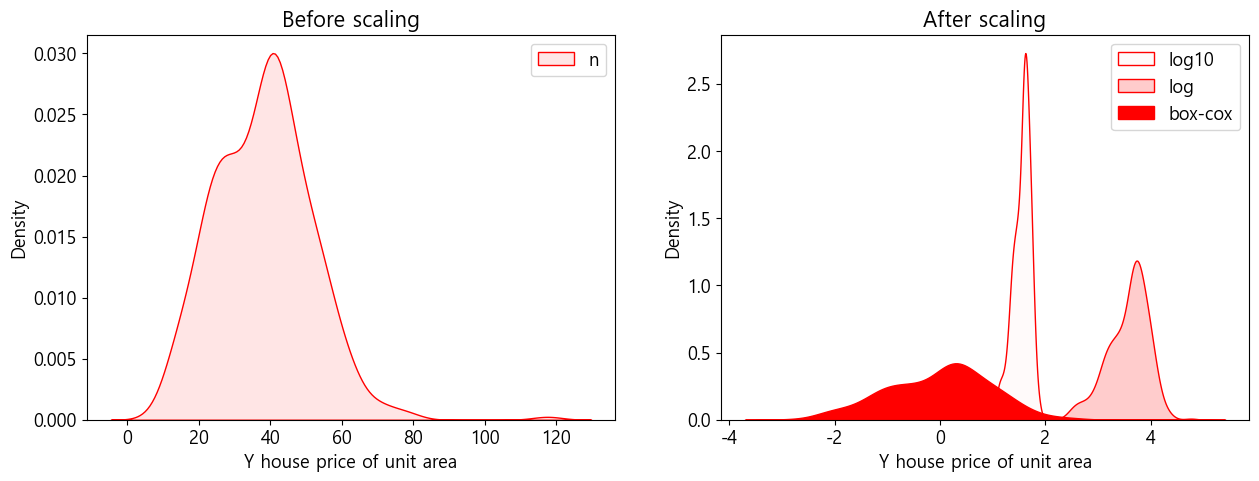

In [130]:
from sklearn.linear_model import LinearRegression
import seaborn as sns

data = [y, y_log, y_log2, y_ptb]
data_title=['no scaling', 'log10', 'log', 'box-cox']
alphas = [0.1, 0.02, 0.2, 1]
fig, ax = plt.subplots(1, 2, figsize=(15,5))
for i, df, a in zip(range(len(data)), data, alphas):
    if i==0:
        sns.kdeplot(df['Y house price of unit area'], ax=ax[0], alpha=a, fill=True, color='red')
        ax[0].legend(data_title[0])
        ax[0].set_title('Before scaling')
    else:
        sns.kdeplot(df['Y house price of unit area'], ax=ax[1], alpha=a, fill=True, color='red')
        ax[1].legend(data_title[1:])
        ax[1].set_title('After scaling')


data = [y, y_log, y_log2, y_log3, y_log4, y_ptb, y_pty]
data_title = ['no scaling', 'log10' 'log', 'log1p', 'abs+log+sign', 'box-cox', 'yeo-johnson']
scores = pd.DataFrame(index=['Train r2', 'Test r2'], columns=data_title)

for df, title in zip(data, data_title): 
    X_train, X_test, y_train, y_test = train_test_split(X, df, random_state=0)
    lr=LinearRegression()
    lr.fit(X_train, y_train)
    pred_train = lr.predict(X_train)
    pred_test = lr.predict(X_test)
    scores.loc['Train r2', title]=lr.score(X_train, y_train)
    scores.loc['Test r2', title]=lr.score(X_test, y_test)
print(scores)

### 순위로 변환
- 수치형 변수를 대소 관계에 따른 순위로 변환
- 순위를 전체 데이터의 수로 나누게 되면, 0부터 1의 범위에 들어가면서 다루기 쉬워짐

In [131]:
print('[Before] feature 별 데이터 분포 확인:')
print(X.describe().loc[['mean', 'std', 'max', 'min'], :], '\n')

rank_X = X.rank(ascending=False)

print('[After] feature 별 데이터 분포 확인:')
print(rank_X.describe().loc[['mean', 'std', 'max', 'min'], :], '\n')

[Before] feature 별 데이터 분포 확인:
             X2           X3         X4
mean  17.712560  1083.885689   4.094203
std   11.392485  1262.109595   2.945562
max   43.800000  6488.021000  10.000000
min    0.000000    23.382840   0.000000 

[After] feature 별 데이터 분포 확인:
              X2          X3          X4
mean  207.500000  207.500000  207.500000
std   119.649372  119.649564  118.840631
max   406.000000  413.500000  381.000000
min     1.000000    1.000000    5.500000 



### 구간 분할 (Binning)
- 연속형 변수를 범주형 변수로 변환하는 방법
    - 같은 간격으로 분할
    - 분위점 기준 분할
    - 구간 구분을 지정하여 분할

In [132]:
# pd.cut을 활용하는 방법

binned1 = pd.cut(X['X2'], 5)
freq_df1 = pd.DataFrame(binned1.value_counts()).reset_index().rename(columns={'X2':'계급', 'count':'빈도'}).sort_values(by='계급', ascending=True)
print('bins수 지정:\n', freq_df1, ']\n')

bin_edges = [0,10,20,30,40,float('inf')]
binned2 = pd.cut(X['X2'], bin_edges, right=False)
freq_df2 = pd.DataFrame(binned2.value_counts()).reset_index().rename(columns={'X2':'계급', 'count':'빈도'}).sort_values(by='계급', ascending=True)
print('bins수 지정:\n', freq_df2, ']\n')

bins수 지정:
                 계급   빈도
1  (-0.0438, 8.76]  101
0    (8.76, 17.52]  146
3   (17.52, 26.28]   54
2   (26.28, 35.04]   77
4    (35.04, 43.8]   36 ]

bins수 지정:
              계급   빈도
1   [0.0, 10.0)  109
0  [10.0, 20.0)  167
3  [20.0, 30.0)   43
2  [30.0, 40.0)   87
4   [40.0, inf)    8 ]



In [133]:
# KBBinsDiscretizer로 분할하는 방법
from sklearn.preprocessing import KBinsDiscretizer

# strategy : 'quantile', 'uniform', 'kmeans'
kb = KBinsDiscretizer(n_bins=5, strategy='quantile')
kb.fit(np.array(X['X2']).reshape(-1,1))
print("bin edges: ", kb.bin_edges_[0])

bin edges:  [ 0.   6.6 13.6 17.6 30.9 43.8]


In [135]:
# 계급리스트인 bin_edges를 만든다.
kbbin = kb.bin_edges_[0]
bin_edges = []
for i in range(len(kbbin)):
    if len(kbbin)-1 != i:
        tuple = (int(kbbin[i]), int(kbbin[i+1]))
        bin_edges.append(tuple)

kbinned = kb.transform(np.array(X['X2']).reshape(-1,1))
# 각 데이터가 어느 구간에 속하는지 원핫인코딩된 희소행렬도 반환
result = pd.DataFrame(kbinned.toarray(), columns=bin_edges)

print(result)

     (0, 6)  (6, 13)  (13, 17)  (17, 30)  (30, 43)
0       0.0      0.0       0.0       0.0       1.0
1       0.0      0.0       0.0       1.0       0.0
2       0.0      1.0       0.0       0.0       0.0
3       0.0      1.0       0.0       0.0       0.0
4       1.0      0.0       0.0       0.0       0.0
..      ...      ...       ...       ...       ...
409     0.0      0.0       1.0       0.0       0.0
410     1.0      0.0       0.0       0.0       0.0
411     0.0      0.0       0.0       1.0       0.0
412     0.0      1.0       0.0       0.0       0.0
413     1.0      0.0       0.0       0.0       0.0

[414 rows x 5 columns]


## 범주형 변수 변환

In [139]:
import pandas as pd

features = ['transmission', 'color', 'odometer_value', 'year_produced', 'engine_fuel', 
            'engine_has_gas', 'engine_type', 'engine_capacity', 'body_type', 'has_warranty', 
            'state', 'drivetrain', 'price_usd']

cars = pd.read_csv('https://raw.githubusercontent.com/blueage98/ML/main/cars.csv').filter(features)
cars.engine_has_gas = cars.engine_has_gas.astype('int64')

cars.head(3)

,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,price_usd
0,automatic,silver,190000,2010,gasoline,0,gasoline,2.5,universal,False,owned,all,10900.0
1,automatic,blue,290000,2002,gasoline,0,gasoline,3.0,universal,False,owned,all,5000.0
2,automatic,red,402000,2001,gasoline,0,gasoline,2.5,suv,False,owned,all,2800.0


### One-hot Encoding
- 범주형 변수의 label이 n개일 때 가변수를 n개 만들어져, 정보가 적은 특징이 대량 생산
- 학습 소요시간이나 메모리가 급증하는 단점
- 따라서 범주형 변수의 Label이 너무 많은 경우, 다른 encoding을 고려하거나 label 수를 줄이는 방법 고려해야 함.
- 선형 모델인 경우에만 사용
- 대규모 데이터셋인 경우는 대규모 분산 최적화 필요

In [160]:
car_clr = cars[['color']]
print('색상 개수 : %d  \n색상 목록 : %s' %(car_clr.nunique(), car_clr.color.unique()))

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
car_clr_enc = pd.DataFrame(enc.fit_transform(car_clr).toarray(), columns=enc.get_feature_names_out())
print('one-hot encoding 결과 feature 개수: ', car_clr_enc.shape[1])
car_clr_enc.head(3)

색상 개수 : 12  
색상 목록 : ['silver' 'blue' 'red' 'black' 'grey' 'other' 'brown' 'white' 'green'
 'violet' 'orange' 'yellow']
one-hot encoding 결과 feature 개수:  12


C:\Users\lsel\AppData\Local\Temp\ipykernel_10648\2880593077.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('색상 개수 : %d  \n색상 목록 : %s' %(car_clr.nunique(), car_clr.color.unique()))


,color_black,color_blue,color_brown,color_green,color_grey,color_orange,color_other,color_red,color_silver,color_violet,color_white,color_yellow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Dummy coding
- 범주형 변수의 label이 n개일 때 가변수를 n개 만들어 버리면 다중공선성 문제 발생
- 이 문제를 방지하기 위해 n-1 개의 가변수를 만드는 방법. 결과적으로 one-hot encoding보다 가변수가 1 적다.
- pd.get_dummpy(drop_first=True)

In [162]:
car_clr = cars[['color']]

car_clr_dummy = pd.get_dummies(car_clr, drop_first=True)
print('dummy encoding 결과 feature 개수: ', car_clr_dummy.shape[1])
car_clr_dummy.head(3)

dummy encoding 결과 feature 개수:  11


,color_blue,color_brown,color_green,color_grey,color_orange,color_other,color_red,color_silver,color_violet,color_white,color_yellow
0,False,False,False,False,False,False,False,True,False,False,False
1,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,False


### 숫자로 표현된 범주형 특성 변환
- 범주형 변수인데 숫자로 인코딩 된 경우. ex) 국가 코드
- pd.get_dummy(columns=['국가코드'])로 지정해주거나, 해당 열의 type을 str로 변경후 get_dummies

In [165]:
# columns를 직접 지정하여 one-hot encoding
has_gas = cars[['engine_has_gas']]
has_gas_enc1 = pd.get_dummies(has_gas, columns=['engine_has_gas'])
has_gas_enc1.head(3)

# 데이터타입을 string으로 변환 후 encoding
print('원본의 데이터타입: ', has_gas.dtypes)
has_gas = has_gas.astype('category') # 혹은 str
print('변경된 데이터타입: ', has_gas.dtypes)

has_gas_enc2 = pd.get_dummies(has_gas)
has_gas_enc2.head(3)

원본의 데이터타입:  engine_has_gas    int64
dtype: object
변경된 데이터타입:  engine_has_gas    category
dtype: object


,engine_has_gas_0,engine_has_gas_1
0,True,False
1,True,False
2,True,False


### Label Encoding
- 범주형 변수인데 Label이 5개인 경우 0~4로 인코딩하는 방법
- 값의 크기와 비교는 의미가 없으므로 트리 기반 알고리즘에서만 사용할 것

In [167]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(cars.engine_fuel)

cars3 = le.transform(cars.engine_fuel)
cars3 = DataFrame(cars3, columns=['engine_fuel'])

print('LabelEncoding 후: ', cars3.engine_fuel.value_counts())

LabelEncoding 후:  engine_fuel
3    24065
0    12872
2     1347
5      235
1       10
4        2
Name: count, dtype: int64


### Feature Hashing
- one-hot encoding 시 특징의 수가 label 수 만큼 증가한다. 반면 FeatureHashing은 그 수를 줄이는 변환이다.
- 원하는 특징의 수를 먼저 정하고, Hash함수를 이용하여 각 label별로 1로 표시할 위치를 결정한다.
- one-hot encoding 시는 label별로 1의 위치가 다르지만, Feature hashing에서는 label이 달라도 위치가 같을 수 있다.
- 구현하기 쉽고, 학습에 비용도 적으며, 새로운 범주 추가도 용이하지만, 
- Hashed Feature에 대해서는 해석이 불가한 문제가 
- Linear 혹은 Kernel 모델에만 적합하다.

In [169]:
from sklearn.feature_extraction import FeatureHasher

n=3 #변수 변환 후 특징의 최종 개수
cols = ['engine_fuel']

fh = FeatureHasher(n_features=n, input_type='string')
hash_df = fh.transform(cars[cols].values)
hash_df = pd.DataFrame(hash_df.todense(), columns=[f"feauture_{i}" for i in range(n)])
print(hash_df.value_counts())

# 3개의 특징으로 4개의 Label을 설명할 수 있으며, 
# 각 Label의 데이터 개수가 원본 수준의 데이터 개수와 유사한 것이 확인된다.
# 원본 데이터 : 24065, 12872, 1347, 235, 10, 2
# 변경 데이터 : 25412, 13107, 10, 2
print(hash_df.head(5))

feauture_0  feauture_1  feauture_2
 0.0        -1.0        0.0           25412
             1.0        0.0           13107
 1.0         0.0        0.0              10
-1.0         0.0        0.0               2
Name: count, dtype: int64
   feauture_0  feauture_1  feauture_2
0         0.0        -1.0         0.0
1         0.0        -1.0         0.0
2         0.0        -1.0         0.0
3         0.0        -1.0         0.0
4         0.0        -1.0         0.0


In [183]:
# Feature Hashing 또다른 예제
from sklearn.feature_extraction import FeatureHasher
h = FeatureHasher(n_features=10)
D = [{'dog': 1, 'cat':2, 'elephant':4},{'dog': 2, 'run': 5}]
f = h.transform(D)
print(f)
print(f.toarray())


  (0, 2)	-4.0
  (0, 3)	-1.0
  (0, 9)	2.0
  (1, 3)	-2.0
  (1, 4)	-5.0
[[ 0.  0. -4. -1.  0.  0.  0.  0.  0.  2.]
 [ 0.  0.  0. -2. -5.  0.  0.  0.  0.  0.]]


### Frequency Encoding
- 각 label의 출현 회수로 범주형 변수를 대체
- 각 label의 출현 회수와 목적 변수 간에 관련이 있을 때 유효
- 따라서 출현 회수가 같은 label이 있는 경우, 주의해야 함.
- encoding 시 학습데이터와 테스트데이터를 분리하면 다른 의미가 되므로 주의해야 함.

In [186]:
cars_part = cars.filter(['color', 'engine_fuel', 'engine_type'])
print('color의 빈도: \n', cars_part['color'].value_counts(), '\n')
#print('color의 데이터: \n', cars_part['color'], '\n')

fe = cars_part.copy()
for col in cars_part.columns:
    freq = cars_part[col].value_counts()
    fe[col] = cars_part[col].map(freq)

print(cars_part.head(5))
print(fe.head(5))

color의 빈도: 
 color
black     7705
silver    6852
blue      5802
white     4212
grey      3751
red       2925
green     2760
other     2688
brown      886
violet     463
yellow     303
orange     184
Name: count, dtype: int64 

    color engine_fuel engine_type
0  silver    gasoline    gasoline
1    blue    gasoline    gasoline
2     red    gasoline    gasoline
3    blue    gasoline    gasoline
4   black    gasoline    gasoline
   color  engine_fuel  engine_type
0   6852        24065        25647
1   5802        24065        25647
2   2925        24065        25647
3   5802        24065        25647
4   7705        24065        25647
